In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import Input, Embedding, Flatten, Lambda, Dense, Reshape, LSTM, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools
from collections import Counter
from utils import data_merger, filter_data
import random
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

In [2]:
# Read the dataset
data = pd.read_excel('./dataset.xlsx', sheet_name='main')
data2 = pd.read_excel('./dataset.xlsx', sheet_name='archive')
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

In [3]:
# Combining the dataset into 1D array or string
answerKey = list(df)[2::]
combinedAnswer = []
for key in answerKey:
    for answer in df[key]:
        if pd.isna(answer): break
        combinedAnswer.append(answer)
badAnswerKey = list(df2)[2::]
combinedBadAnswer = []
for key in badAnswerKey:
    for badAnswer in df2[key]:
        if pd.isna(badAnswer): break
        combinedBadAnswer.append(badAnswer)

print(f"Total Raw Answer: {len(combinedAnswer)}")
print(f"Total Raw Bad Answer: {len(combinedBadAnswer)}")

Total Raw Answer: 2720
Total Raw Bad Answer: 1065


In [4]:
# filtering the good type of answer from both dataset
# the filter is detect a word 'saya' and a coma within 10 first sentences
goodAnswer = []
badAnswer = []
for answer in combinedAnswer:
    splitAnswer = answer.split(' ')
    sentence = ' '.join(splitAnswer[:10]).lower()
    if 'saya' in sentence and ',' in sentence:
        goodAnswer.append(sentence)
    else :
        badAnswer.append(sentence)
for answer in combinedBadAnswer:
    splitAnswer = answer.split(' ')
    sentence = ' '.join(splitAnswer[:10]).lower()
    if 'saya' in sentence and ',' in sentence:
        goodAnswer.append(sentence)
    else :
        badAnswer.append(sentence)
        
print(f"Total Good Answer: {len(goodAnswer)}")
print(f"Total Bad Answer: {len(badAnswer)}")

Total Good Answer: 1032
Total Bad Answer: 2753


In [5]:
# set a labels
labels = pd.Series(np.concatenate([np.ones(len(goodAnswer)), np.zeros(len(badAnswer))], axis=0))
print("Final Combined Labels:", len(labels))

Final Combined Labels: 3785


In [6]:
# combining the good and bad answer
combinedData = np.concatenate((goodAnswer, badAnswer))
print("Final Combined Data:", len(combinedData))

Final Combined Data: 3785


In [7]:
# shuffling the answer for good training and validation split
combined = list(zip(combinedData, labels))
random.shuffle(combined)
combined1, combined2 = zip(*combined)

In [8]:
# counting vocabulary size to avoid overfitting
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(combinedData)
vocab_size = len(vectorizer.get_feature_names_out())
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 2381


In [9]:
training_size = round(len(combinedData) * 0.95)
max_length = 10
embedding_dim = 16

In [10]:
# splitting training and validation data
training_sentences = combinedData[0:training_size]
testing_sentences = combinedData[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [11]:
# converting the data into sequences and give a padding
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [17]:
# declare the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 16)            38096     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 38,673
Trainable params: 38,673
Non-trainable params: 0
__________________________________________________

In [18]:
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
113/113 - 1s - loss: 0.6348 - accuracy: 0.7119 - val_loss: 0.3733 - val_accuracy: 1.0000 - 655ms/epoch - 6ms/step
Epoch 2/10
113/113 - 0s - loss: 0.5585 - accuracy: 0.7161 - val_loss: 0.2731 - val_accuracy: 1.0000 - 119ms/epoch - 1ms/step
Epoch 3/10
113/113 - 0s - loss: 0.4623 - accuracy: 0.7917 - val_loss: 0.1892 - val_accuracy: 0.9841 - 123ms/epoch - 1ms/step
Epoch 4/10
113/113 - 0s - loss: 0.3870 - accuracy: 0.8404 - val_loss: 0.1652 - val_accuracy: 0.9630 - 126ms/epoch - 1ms/step
Epoch 5/10
113/113 - 0s - loss: 0.3389 - accuracy: 0.8629 - val_loss: 0.1294 - val_accuracy: 0.9683 - 124ms/epoch - 1ms/step
Epoch 6/10
113/113 - 0s - loss: 0.2958 - accuracy: 0.8832 - val_loss: 0.1475 - val_accuracy: 0.9471 - 120ms/epoch - 1ms/step
Epoch 7/10
113/113 - 0s - loss: 0.2687 - accuracy: 0.8949 - val_loss: 0.1429 - val_accuracy: 0.9471 - 120ms/epoch - 1ms/step
Epoch 8/10
113/113 - 0s - loss: 0.2449 - accuracy: 0.9063 - val_loss: 0.1541 - val_accuracy: 0.9418 - 118ms/epoch - 1ms/step


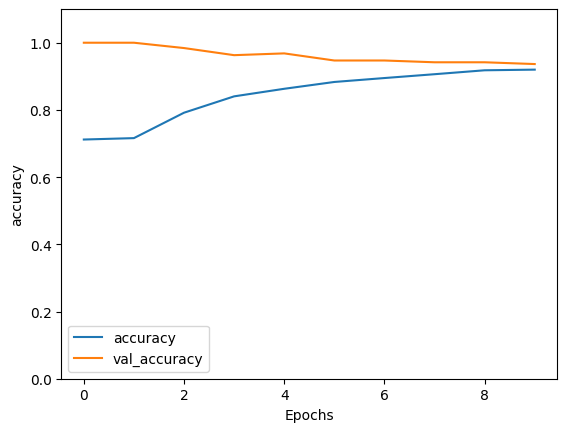

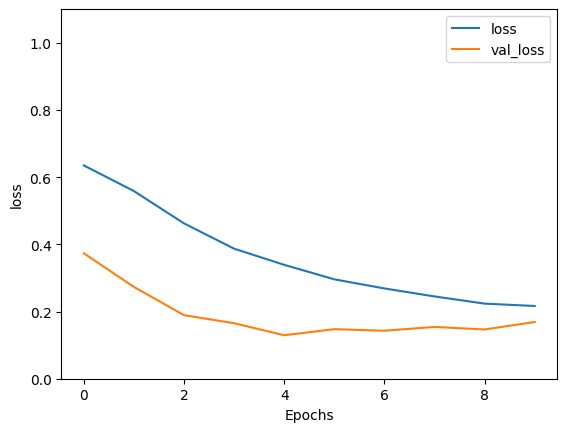

In [19]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])

    plt.ylim(top=1.1, bottom=0)

    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
def predict(text, treshold=0.5):
    input_sequence = tokenizer.texts_to_sequences([text])
    padded_input = pad_sequences(input_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded_input)
    threshold = 0.5
    predicted_class = 1 if predictions[0][0] > threshold else 0
    print('Bagus' if predicted_class == 1 else 'Kurang Bagus')
    return 1 if predicted_class == 1 else 0

In [27]:
predict("saya biasanya membuat daftar prioritas untuk menentukan tindakan yang paling mendesak.")

1/1 [==============================] - 0s 20ms/step
Kurang Bagus


0

In [29]:
predict("Ketika saya dihadapkan pada masalah, saya biasanya membuat daftar prioritas untuk menentukan tindakan yang paling mendesak.")

1/1 [==============================] - 0s 26ms/step
Bagus


1

With treshold of 0.5, the predict function will return a result 0 or 1,
0 means the sentences is bad, and 1 means the sentences is good